In [2]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [4]:
#Display  samples and sample_rate 
train_audio_path = 'C:/Users/dell/Downloads/Compressed/AMHARIC/data/train/wav/tr_56_tr01056.wav'
samples, sample_rate = librosa.load(train_audio_path)
print(samples)
print(sample_rate)

[-0.0052909  -0.00607967 -0.00510738 ... -0.00638237 -0.0049306
  0.        ]
22050


In [7]:
audio, rate=librosa.load('C:/Users/dell/Downloads/Compressed/AMHARIC/data/train/wav/tr_56_tr01056.wav')

In [8]:
ipd.Audio(samples, rate=sample_rate)

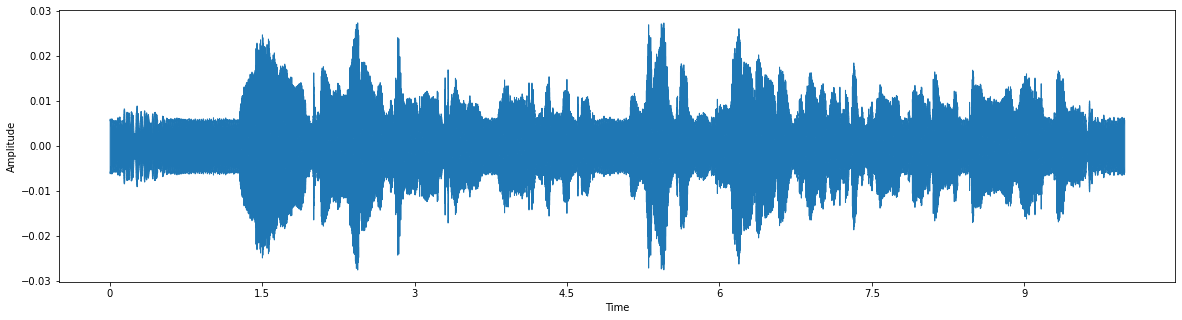

In [10]:
#plot our sample wav file 
%matplotlib inline
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
plt.xlabel("Time")
plt.ylabel('Amplitude')
librosa.display.waveshow(samples, sr=sample_rate)

In [11]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [12]:
spe_samples,frequency=spectrogram(samples)

In [13]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 